# Аналитика в Яндекс.Афише

Для оптимизации маркетинговых затрат для сервиса по продаже электронных билетов нужно рассчитать:
- [продуктовые метрики,](#section1)
- [метрики электронной коммерции,](#section2)
- [маркетинговые метрики.](#section3)

## Шаг 1: Загрузка данных и подготовка к анализу

In [1]:
import pandas as pd
from IPython.display import display 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

sessions = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [2]:
def get_info(data):
    display(data.head(10))
    data.info()
    
get_info(sessions)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [3]:
get_info(orders)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [4]:
get_info(costs)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


В распоряжении есть 359 400 записей о посещениях сайта, 50 415 заказах и 10 маркетинговых кампаниях, проведенных за период. Пропущенных значений нет.

Даты будут приведены к типу datetime и названия колонок унифицированы.

In [5]:
sessions.columns = sessions.columns.str.lower()
sessions.columns = sessions.columns.str.replace(' ', '_')

orders.columns = orders.columns.str.lower()
orders.columns = orders.columns.str.replace(' ', '_')

In [6]:
sessions['start_ts'] = sessions['start_ts'].astype('datetime64')
sessions['end_ts'] = sessions['end_ts'].astype('datetime64')

orders['buy_ts'] = orders['buy_ts'].astype('datetime64')

costs['dt'] = costs['dt'].astype('datetime64')

Для когортного анализа требуется выделить отдельные колонки:
- дата, месяц, год и неделя начала сессии; 
- дата первой сессии (когорта), месяц жизни когорты; 


- дата, неделя, месяц и год заказа; 
- дата первого заказа (когорта), месяц жизни когорты.

In [7]:
sessions['start_date'] = sessions['start_ts'].dt.date
sessions['start_month'] = sessions['start_ts'].astype('datetime64[M]')
sessions['start_year'] = sessions['start_ts'].dt.year
sessions['start_week'] = sessions['start_ts'].dt.week

first_session_month = sessions.groupby('uid')['start_ts'].min()
first_session_month.name = 'first_session_ts'
sessions = sessions.join(first_session_month, on='uid')
sessions['first_session_month'] = sessions['first_session_ts'].astype('datetime64[M]')
sessions['lifetime'] = ((sessions['start_month'] - sessions['first_session_month']) / np.timedelta64(1, 'M')).round().astype('int')

orders['buy_date'] = orders['buy_ts'].dt.date
orders['buy_week'] = orders['buy_ts'].dt.week
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['buy_year'] = orders['buy_ts'].dt.year
first_order_month = orders.groupby('uid')['buy_ts'].min()
first_order_month.name = 'first_order_ts'
orders = orders.join(first_order_month, on='uid')
orders['first_order_month'] = orders['first_order_ts'].astype('datetime64[M]')
orders['lifetime'] = ((orders['buy_month'] - orders['first_order_month']) / np.timedelta64(1, 'M')).round().astype('int')

In [8]:
sessions

,device,end_ts,source_id,start_ts,uid,start_date,start_month,start_year,start_week,first_session_ts,first_session_month,lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-01,2017,51,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-01,2018,8,2018-02-19 16:53:00,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,2017,26,2017-07-01 01:54:00,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-01,2018,20,2018-03-09 20:05:00,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-01,2017,52,2017-12-27 14:06:00,2017-12-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,2017-07-01,2017,30,2017-07-29 19:07:00,2017-07-01,0
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,2018-01-01,2018,4,2018-01-25 17:38:00,2018-01-01,0
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,2018-03-01,2018,9,2018-03-03 10:12:00,2018-03-01,0
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,2017-11-01,2017,44,2017-11-02 10:12:00,2017-11-01,0


## Анализ данных

### Продуктовые метрики
<a class="anchor" id="section1"></a>

#### DAU, WAU, MAU

In [9]:
dau = sessions.groupby('start_date')['uid'].nunique()
dau.name = 'dau'
dau_total = int(dau.mean())

wau = sessions.groupby(['start_year', 'start_week'])['uid'].nunique()
wau.name = 'wau'
wau_total = int(wau.mean())

mau = sessions.groupby(['start_year', 'start_month'])['uid'].nunique()
mau.name = 'mau'
mau_total = int(mau.mean())

print('Людей пользуются в день: ', dau_total)
print('Людей пользуются в неделю: ', wau_total)
print('Людей пользуются в месяц: ', mau_total)

Людей пользуются в день:  907
Людей пользуются в неделю:  5716
Людей пользуются в месяц:  23228


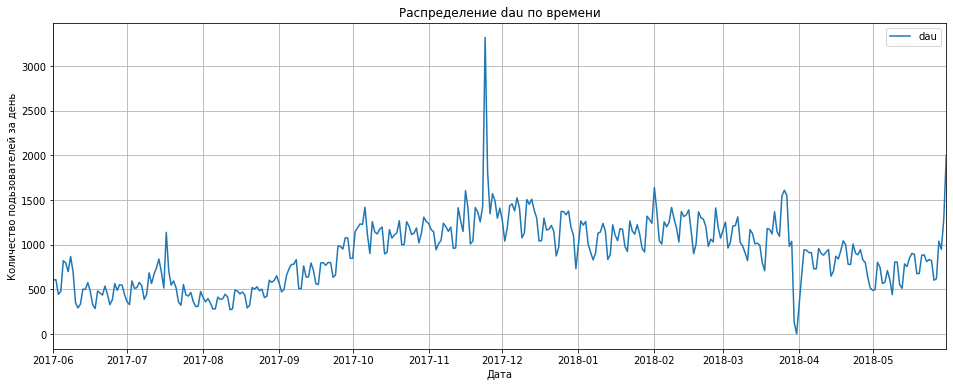

In [10]:
def plotting(metric, period):
    metric.plot(figsize=(16,6), grid=True, legend=True)
    plt.title('Распределение '+ metric.name+ ' по времени')
    plt.xlabel('Дата')
    plt.ylabel('Количество подьзователей за ' + period)
    plt.show()
    
plotting(dau, 'день')

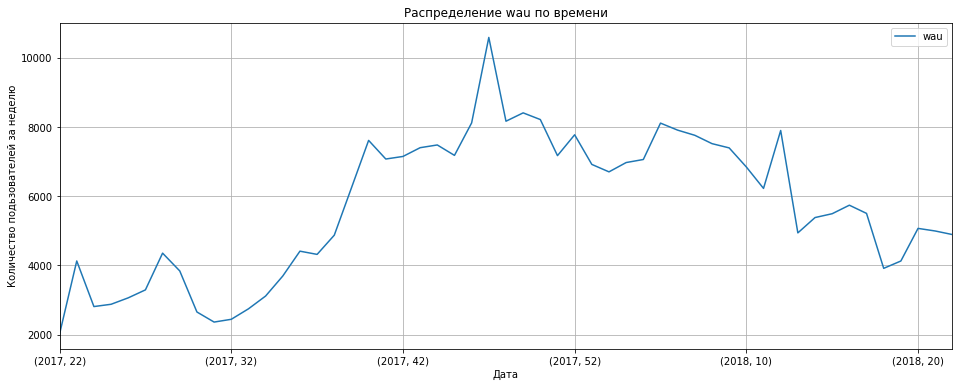

In [11]:
plotting(wau, 'неделю')

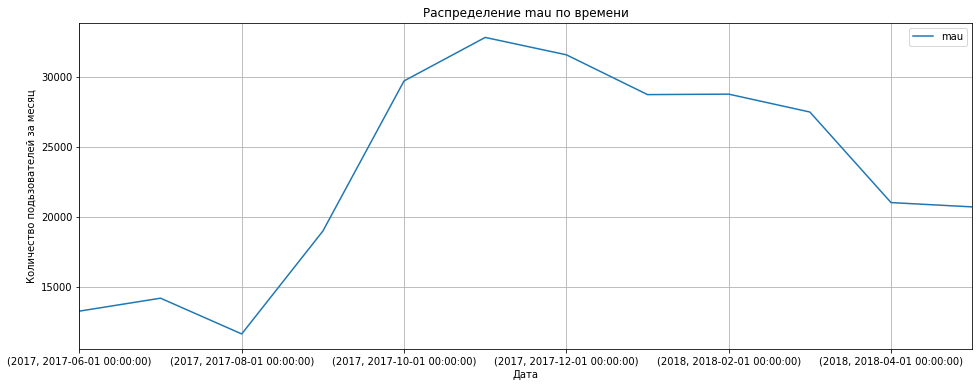

In [12]:
plotting(mau, 'месяц')

In [13]:
sticky_wau = 100 * ( dau_total / wau_total )
sticky_mau = 100 * ( dau_total / mau_total )

print(int(sticky_wau))
print(int(sticky_mau))

15
3


#### Вывод

В среднем ресурсом Яндекс.Афиша пользуются:
- 907 людей в день;
- 5716 людей в неделю;
- 23228 людей в месяц.

**Sticky_mau** всего 3 %. Показатель низкий, а значит, что механизмы вовзрата клиента требуют улучшения.

Больше всего пользуются ресурсом в ноябре. За этот месяц на сайт зашли около 38 000 человек.
Достаточно популярные месяцы - октябрь, ноябрь, январь, февраль и март.
Летние месяцы самые непопулярные по использованию ресурса.

Так же пик использования приложения приходится на 47 неделю, с 20 по 26 ноября. В это время, вероятно, люди покупают билеты на новогодние представления.

#### Сколько раз за день пользователи в среднем заходят на сайт

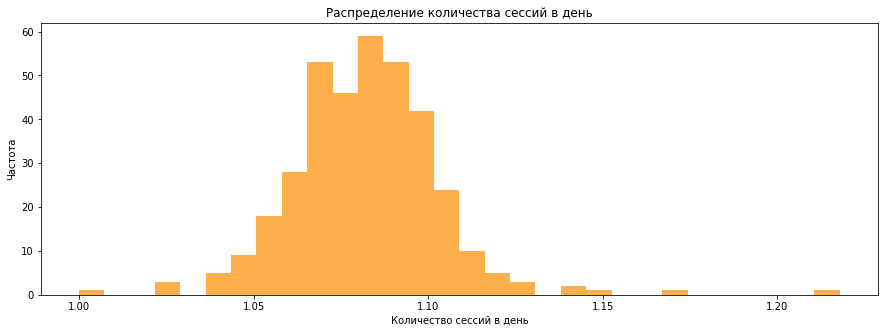

In [14]:
sessions_by_day = sessions.groupby('start_date')['start_ts'].count().reset_index()
sessions_by_users = sessions.groupby('start_date')['uid'].nunique().reset_index()
traffics = sessions_by_day.merge(sessions_by_users, on='start_date')
traffics.columns = ['start_date', 'n_sessions', 'n_users']
traffics['traffic'] = traffics['n_sessions'] / traffics['n_users']
traffics

traffics['traffic'].plot(kind='hist',bins=30, figsize=(15,5), color='darkorange', alpha=0.7)
plt.title('Распределение количества сессий в день')
plt.xlabel('Количество сессий в день')
plt.ylabel('Частота')
plt.show()

In [15]:
traffics['traffic'].median()

1.0824875552419868

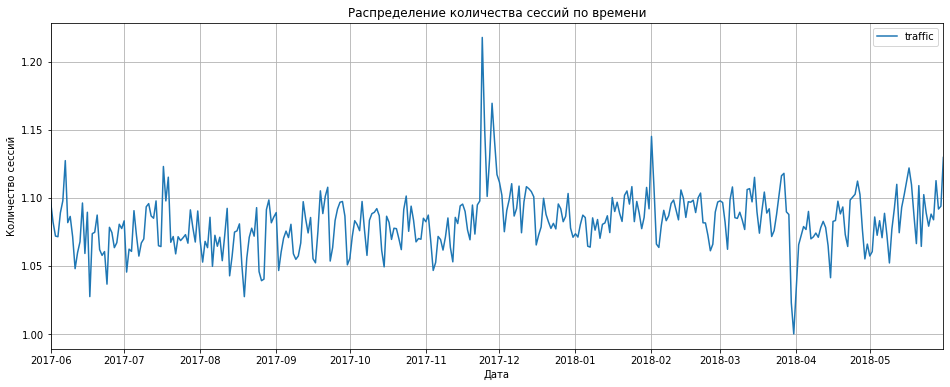

In [16]:
traffics[['start_date', 'traffic']].plot(x='start_date', figsize=(16,6), grid=True, legend=True)
plt.title('Распределение количества сессий по времени')
plt.xlabel('Дата')
plt.ylabel('Количество сессий')
plt.show()

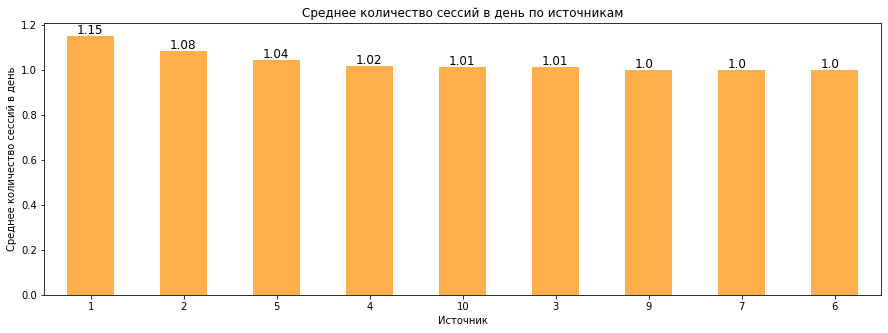

In [17]:
n_sessions_by_source = sessions.groupby(['start_date', 'source_id'])['start_ts'].count().reset_index()
n_users_by_source = sessions.groupby(['start_date', 'source_id'])['uid'].nunique().reset_index()
traffics_by_source = n_sessions_by_source.merge(n_users_by_source, on=['start_date', 'source_id'])
traffics_by_source.columns = ['start_date', 'source_id', 'n_sessions', 'n_users']
traffics_by_source['trafic'] = traffics_by_source['n_sessions'] / traffics_by_source['n_users']
traffics_by_source

traffics_by_source = traffics_by_source.groupby('source_id')['trafic'].median().sort_values(ascending=False)

ax = traffics_by_source.plot(kind='bar', title='Среднее количество сессий в день по источникам', 
                             figsize=(15,5), color='darkorange', alpha=0.7)

for i in ax.patches:
    ax.text(i.get_x()+0.1, i.get_height()+0.01, round(i.get_height(), 2), fontsize=12, color='black')
    
plt.xlabel('Источник')
plt.ylabel('Среднее количество сессий в день')
plt.xticks(rotation=0)
plt.show()

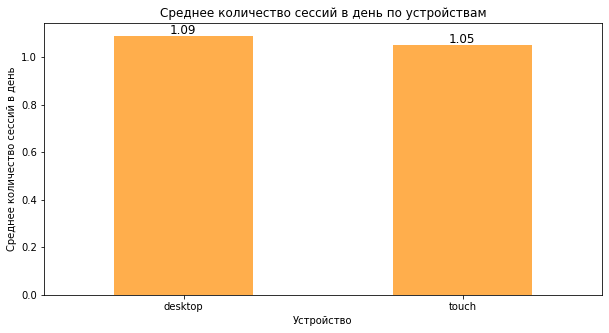

In [18]:
sessions_by_device = sessions.groupby(['start_date', 'device'])['start_ts'].count().reset_index()
users_by_device = sessions.groupby(['start_date', 'device'])['uid'].nunique().reset_index()
traffics_by_device = sessions_by_device.merge(users_by_device, on=['start_date', 'device'])
traffics_by_device.columns = ['start_date', 'device', 'n_sessions', 'n_users']
traffics_by_device['traffic'] = traffics_by_device['n_sessions'] / traffics_by_device['n_users']
traffics_by_device

traffics_by_device = traffics_by_device.groupby('device')['traffic'].median().sort_values(ascending=False)

ax = traffics_by_device.plot(kind='bar', title='Среднее количество сессий в день по устройствам', 
                             figsize=(10,5), color='darkorange', alpha=0.7)

for i in ax.patches:
    ax.text(i.get_x()+0.2, i.get_height()+0.01, round(i.get_height(), 2), fontsize=12, color='black')
    
plt.xlabel('Устройство')
plt.ylabel('Среднее количество сессий в день')
plt.xticks(rotation=0)
plt.show()

#### Вывод

Среднее количество сессий в день на 1 пользователя - 1,08.

Показатель посещаемости для Источника 1 самый высокий - 1,15 сессий в день на одного пользователя.

Посещаемость на всех видах устройств примерно одинакова.

#### ASL

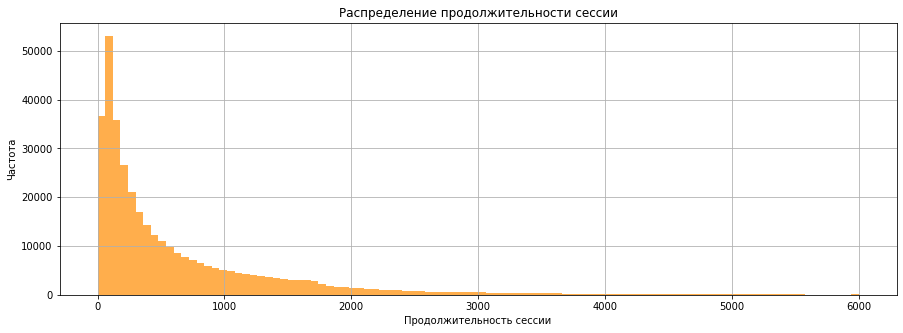

In [19]:
sessions['session_duration'] = (sessions['end_ts'] - sessions['start_ts']).dt.seconds
sessions['session_duration'].hist(bins=100, range=(0, 6000), figsize=(15,5), color='darkorange', alpha=0.7)
plt.title('Распределение продолжительности сессии')
plt.xlabel('Продолжительность сессии')
plt.ylabel('Частота')
plt.show()

In [20]:
asl = sessions['session_duration'].mode()[0]
print('В среднем одна сессия длится ', asl, 'секунд')

В среднем одна сессия длится  60 секунд


In [21]:
duration_by_source = sessions.groupby('source_id')['session_duration'].agg(pd.Series.mode)
duration_by_source

source_id
1                                 60
2                                 60
3                                 60
4                                 60
5                                 60
6     [0, 180, 360, 480, 1260, 5940]
7                                120
9                                 60
10                                60
Name: session_duration, dtype: object

In [22]:
duration_by_device = sessions.groupby('device')['session_duration'].agg(pd.Series.mode)
duration_by_device

device
desktop    60
touch      60
Name: session_duration, dtype: int64

#### Вывод

Продолжительность сессий имеет распределение Пуассона. Для оценки среднего такого распределения возьмем моду. В среднем одна сессия длится 60 секунд.

Время, проведенное пользователями, которые перешли на сайт из источников 6 и 7, выбивается из общей массы.

#### Retention Rate

In [23]:
sessions_cohort_size = sessions.groupby('first_session_month')['uid'].nunique()
sessions_cohort_size.name = 'cohort_size'

sessions_by_cohort = sessions.groupby(['first_session_month', 'lifetime'])['uid'].nunique().reset_index()
sessions_by_cohort = sessions_by_cohort.rename(columns=({'uid': 'n_users'}))
sessions_by_cohort = sessions_by_cohort.merge(sessions_cohort_size, on='first_session_month')


In [24]:
sessions_by_cohort['retention'] = sessions_by_cohort['n_users'] / sessions_by_cohort['cohort_size']

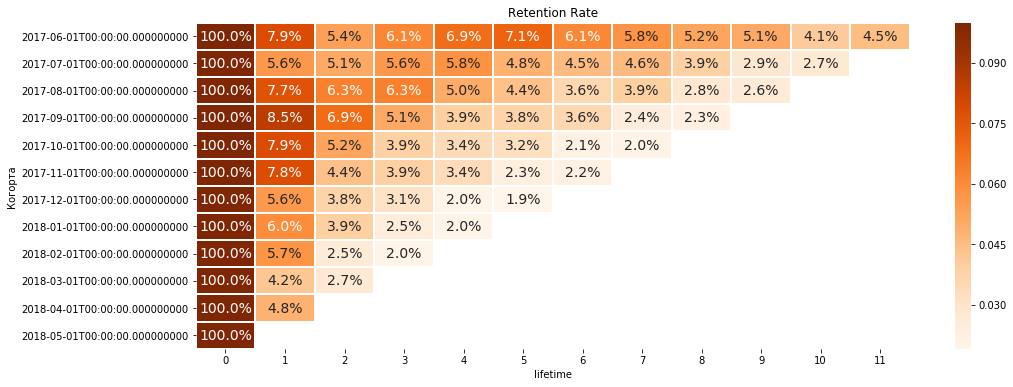

In [25]:
retention_pivot = sessions_by_cohort.pivot_table(index='first_session_month', columns='lifetime', values='retention')

plt.figure(figsize=(16,6))
ax = sns.heatmap(retention_pivot, annot=True, linewidths=1, linecolor='white', fmt='.1%', annot_kws={'size':14}, 
                 cbar=True, cmap='Oranges', vmax=0.1)
plt.ylabel('Когорта')
plt.title('Retention Rate')
plt.show()

#### Вывод

Уже на второй месяц жизни когорты коэффициент удержания меньше 10%.
В целом, от когорты к когорте Retention Rate убывает на одних и тех же жизненных циклах. Это говорит о том, что поведение пользователей с каждой новой когортой меняется. 

Самый высокий коэффициент удержания у когорты 06-2017.

Повышение Retention Rate на 6 месяце жизни для когорты 06-2017, на 4 для когорты 07.2017, говорит о том, что к декабрю больше пользователей возвращаются на сайт.

### Вывод

В среднем ресурсом Яндекс.Афиша пользуются:
- 907 людей в день;
- 5716 людей в неделю;
- 23228 людей в месяц.

**Sticky_mau** всего 3 %. Показатель низкий, а значит, что механизмы вовзрата клиента требуют улучшения.

Больше всего пользуются ресурсом в ноябре. За этот месяц на сайт зашли около 38 000 человек.
Достаточно популярные месяцы - октябрь, ноябрь, январь, февраль и март.
Летние месяцы самые непопулярные по использованию ресурса.

Так же пик использования приложения приходится на 47 неделю, с 20 по 26 ноября. В это время, вероятно, люди покупают билеты на новогодние представления.

Среднее количество сессий в день на 1 пользователя - 1,08.

Показатель посещаемости для Источника 1 самый высокий - 1,15 сессий в день на одного пользователя.

Посещаемость на всех видах устройств примерно одинакова.

В среднем одна сессия длится 60 секунд.

Время, проведенное пользователями, которые перешли на сайт из источников 6 и 7, выбивается из общей массы.

Уже на второй месяц жизни когорты коэффициент удержания меньше 10%.
В целом, от когорты к когорте Retention Rate убывает на одних и тех же жизненных циклах. Это говорит о том, что поведение пользователей с каждой новой когортой меняется. 

Самый высокий коэффициент удержания у когорты 06-2017.

Повышение Retention Rate на 6 месяце жизни для когорты 06-2017, на 4 для когорты 07.2017, говорит о том, что к декабрю больше пользователей возвращаются на сайт.

### Метрики электронной коммерции
<a class="anchor" id="section2"></a>

#### Среднее время с момента первого посещения сайта до совершения покупки

In [26]:
first_session = sessions[['uid', 'first_session_ts']].drop_duplicates()

first_order = orders[['uid', 'first_order_ts']].drop_duplicates()

duration_of_purchase = first_session.merge(first_order, on='uid')
duration_of_purchase['time_of_purchase'] = (duration_of_purchase['first_order_ts'] - duration_of_purchase['first_session_ts'])\
                                                                                                                    .dt.seconds
duration_of_purchase

,uid,first_session_ts,first_order_ts,time_of_purchase
0,16174680259334210214,2018-03-09 20:05:00,2018-03-09 20:25:00,1200
1,16007536194108375387,2017-09-03 21:35:00,2017-09-04 12:46:00,54660
2,8056418121947262981,2017-06-04 14:17:00,2017-06-25 08:54:00,67020
3,18188358787673499603,2018-02-10 12:17:00,2018-02-12 19:48:00,27060
4,2307401184189569202,2017-09-23 23:27:00,2017-09-27 09:23:00,35760
...,...,...,...,...
36518,6752020629696526518,2017-12-04 12:42:00,2017-12-04 12:46:00,240
36519,11750532881998794555,2017-11-20 23:33:00,2017-11-20 23:43:00,600
36520,11202626539189016002,2017-11-29 20:27:00,2017-11-29 20:33:00,360
36521,12734910664455613822,2018-04-23 21:11:00,2018-04-23 21:16:00,300


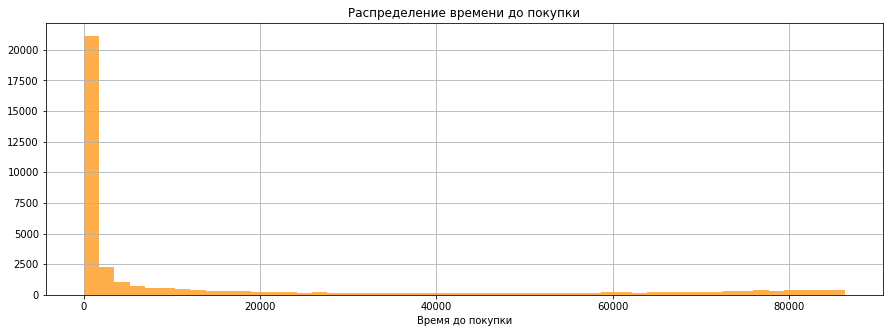

In [27]:
duration_of_purchase['time_of_purchase'].hist(bins=50, figsize=(15,5), color='darkorange', alpha=0.7)
plt.title('Распределение времени до покупки')
plt.xlabel('Время до покупки')
plt.show()

In [28]:
time_of_purchase = duration_of_purchase['time_of_purchase'].mode()[0]
print('В среднем люди начинают покупать через ', time_of_purchase, 'секунд.')

В среднем люди начинают покупать через  60 секунд.


#### Вывод

Время от первой сессии до первой покупки имеет распределение Пуассона, поэтому для оценки среднего возьмем моду. В среднем клиент совершает покупку через 60 секунд после первого посещения сайта. Это хороший показатель. За 60 секунд новый пользователь выбрал билеты и оплатил покупку.

#### Среднее количество покупок на 1 клиента за 6 месяцев

In [29]:
# фильтрация когорт, по которым есть данные за все первые 6 месяцев жизни когорты
orders_cohort_six_month = orders[(orders['lifetime'] <= 5) & (orders['first_order_month'] < '2018-01-01')]\
                                        .groupby('first_order_month').agg({'uid':'nunique', 'buy_ts':'count'})
orders_cohort_six_month['avg_orders'] = orders_cohort_six_month['buy_ts'] / orders_cohort_six_month['uid']
orders_cohort_six_month

,uid,buy_ts,avg_orders
first_order_month,,,
2017-06-01,2023,3441,1.700939
2017-07-01,1923,2664,1.385335
2017-08-01,1370,1969,1.437226
2017-09-01,2581,3653,1.415343
2017-10-01,4340,5794,1.335023
2017-11-01,4081,5798,1.420730
2017-12-01,4383,5894,1.344741


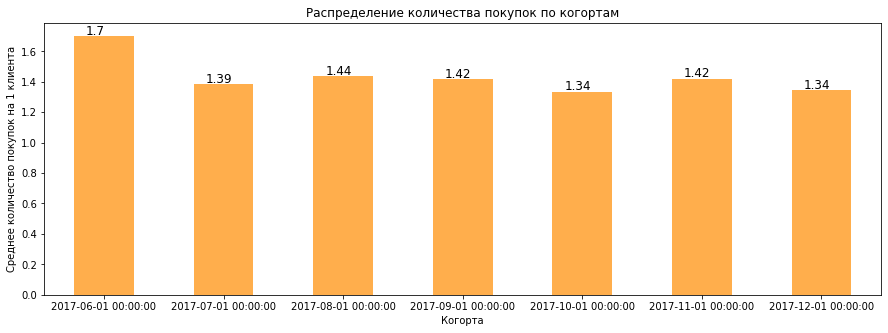

In [30]:
ax = orders_cohort_six_month[ 'avg_orders'].plot(kind='bar', figsize=(15,5), title='Распределение количества покупок по когортам',
                                           color='darkorange', alpha=0.7)
plt.xticks(rotation=0)
plt.xlabel('Когорта')
plt.ylabel('Среднее количество покупок на 1 клиента')

for i in ax.patches:
    ax.text(i.get_x()+0.1, i.get_height()+0.01, round(i.get_height(), 2), fontsize=12, color='black')
    
plt.show()

#### Вывод

Больше всего клиентов, оформивших покупку более одного раза за первые 6 месяцев жизни, у когорты 06-2017 - около 70%.
Для остальных когорт среднее количество покупок на 1 покупателя - 1,4.

#### Средняя выручка с пользователя

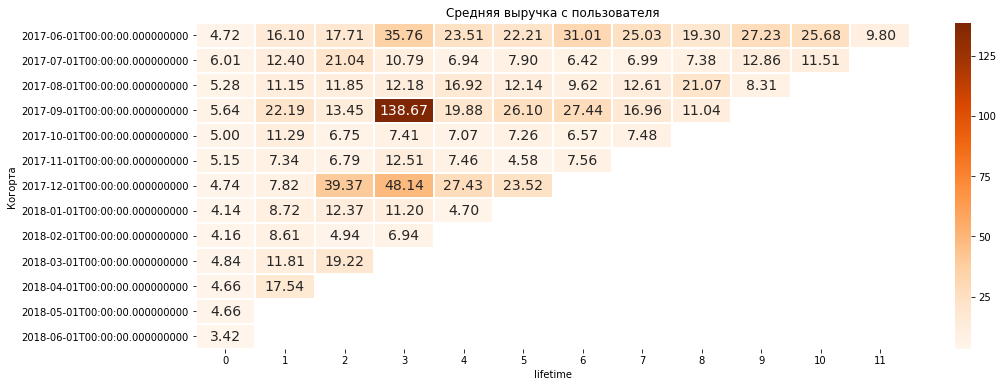

In [31]:
orders_by_cohorts = orders.groupby(['first_order_month', 'lifetime']).agg({'uid':'nunique', 'revenue':'sum'})
orders_by_cohorts['revenue_per_user'] = orders_by_cohorts['revenue'] / orders_by_cohorts['uid']
revenue_per_user_pivot = orders_by_cohorts.pivot_table(index='first_order_month', columns='lifetime', 
                                                               values='revenue_per_user')

plt.figure(figsize=(16,6))
sns.heatmap(revenue_per_user_pivot, fmt='.2f', linewidths=1, annot=True, cmap='Oranges', annot_kws={'size':14})
plt.title('Средняя выручка с пользователя')
plt.ylabel('Когорта')
plt.show()

In [32]:
revenue_per_user_pivot.mean(axis=1)

first_order_month
2017-06-01    21.505471
2017-07-01    10.021397
2017-08-01    12.112811
2017-09-01    31.262996
2017-10-01     7.354802
2017-11-01     7.341991
2017-12-01    25.167608
2018-01-01     8.224346
2018-02-01     6.162607
2018-03-01    11.957455
2018-04-01    11.096335
2018-05-01     4.660562
2018-06-01     3.420000
dtype: float64

#### Вывод

Покупатели когорт 09-2017, 12-2017, 06-2017 совершают самые большие покупки. В среднем одна покупка приносит от 21 до 31 у.е..

У когорт 07-2017, 08-2017, 03-2018, 04-2018 средний чек 11 у.е..

Самые маленькие покупки у когорт 05-2018 и 06-2018.

Общее сходство в поведении всех когорт - в первом месяце жизни когорты средний чек самый низкий. Т.е. покупатели тратят больше денег со второй покупки.

Самые большие покупки некоторые когорты сделали на 4 месяце жизни, затем следующий пик на 7.

#### LTV

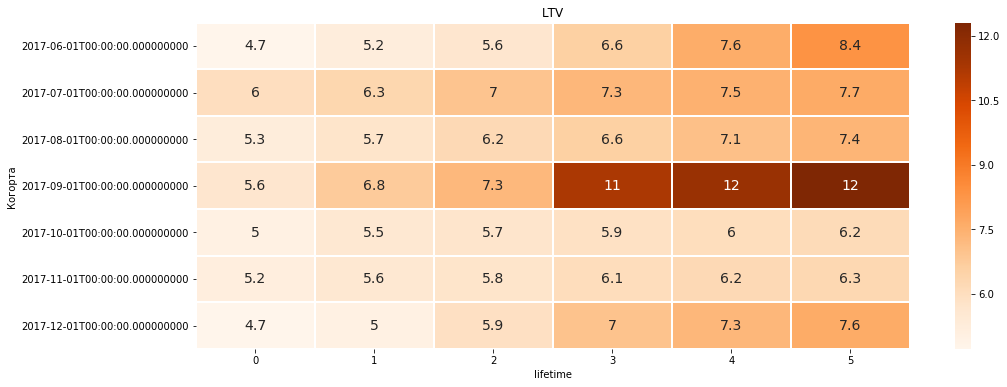

In [33]:
orders_by_cohorts = orders_by_cohorts.reset_index()
orders_by_cohorts.columns = ['first_order_month', 'lifetime', 'n_buyers', 'revenue', 'revenue_per_user']
orders_cohort_size = orders_by_cohorts[orders_by_cohorts['lifetime']==0][['first_order_month', 'n_buyers']]
orders_cohort_size = orders_cohort_size.rename(columns=({'n_buyers':'cohort_size'}))

orders_by_cohort = pd.merge(orders_by_cohorts, orders_cohort_size, on='first_order_month')
orders_by_cohort['ltv'] = orders_by_cohort['revenue'] / orders_by_cohort['cohort_size']

pivot_ltv = orders_by_cohort[orders_by_cohort['lifetime']<=5].pivot_table(index='first_order_month', 
                                                                          columns='lifetime', 
                                                                          values='ltv', 
                                                                          aggfunc='mean').dropna()
pivot_ltv = pivot_ltv.cumsum(axis=1)

plt.figure(figsize=(16,6))
sns.heatmap(pivot_ltv, linewidths=1, cmap='Oranges', annot=True, annot_kws={'size':14})
plt.title('LTV')
plt.ylabel('Когорта')
plt.show()

#### Вывод
Самые ценные покупатели когорты 09-2017. Каждый в среднем принес 12 у.е. прибыли за первые 6 месяцев использования сервиса.

Выручка от покупателей когорт 10-2017 и 11-2017 в среднем 6,2 у.е - это самый низкий показатель по сравнению с остальными.

Покупатели остальных когорт приносят в среднем 7,7 у.е выручки каждый.

### Вывод

За 60 секунд новый пользователь выбрал билеты и оплатил покупку.

Больше всего клиентов, оформивших покупку более одного раза за первые 6 месяцев жизни, у когорты 06-2017 - около 70%.
Для остальных когорт среднее количество покупок на 1 покупателя - 1,4.

Покупатели когорт 09-2017, 12-2017, 06-2017 совершают самые большие покупки. В среднем одна покупка приносит от 21 до 31 у.е..

У когорт 07-2017, 08-2017, 03-2018, 04-2018 средний чек 11 у.е..

Самые маленькие покупки у когорт 05-2018 и 06-2018.

Общее сходство в поведении всех когорт - в первом месяце жизни когорты средний чек самый низкий. Т.е. покупатели тратят больше денег со второй покупки.

Самые большие покупки некоторые когорты сделали на 4 месяце жизни, затем следующий пик на 7.

Самые ценные покупатели когорты 09-2017. Каждый в среднем принес 12 у.е. прибыли за первые 6 месяцев использования сервиса.

Выручка от покупателей когорт 10-2017 и 11-2017 в среднем 6,2 у.е - это самый низкий показатель по сравнению с остальными.

Покупатели остальных когорт приносят в среднем 7,7 у.е выручки каждый.

### Маркетинговые метрики
<a class="anchor" id="section3"></a>

#### Общая сумма расходов на маркетинг

In [34]:
total_cost = costs['costs'].sum()
total_cost

329131.62

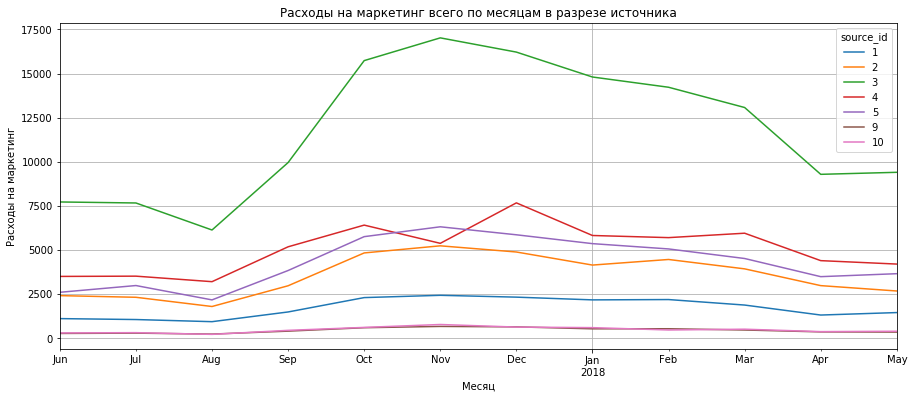

In [35]:
costs['cost_month'] = costs['dt'].astype('datetime64[M]')
costs_by_source = costs.pivot_table(index='cost_month', columns='source_id', values='costs', aggfunc='sum')
costs_by_source.plot(grid=True, figsize=(15,6))
plt.xlabel('Месяц')
plt.ylabel('Расходы на маркетинг')
plt.title('Расходы на маркетинг всего по месяцам в разрезе источника')
plt.show()

#### Вывод
С июня 2017 по конец мая 2018 года было потрачено 329131.62 у.е. на привлечение клиентов.

Самые большие затрат на источник 3 и меньшие - на источник 10 и 1.

Пик маркетинговых вложений на привлечение клиентов приходится на ноябрь-декабрь. В ноябре на источник 3 было потрачено около 17 000 у.е. В декабре на источник 4, из которого было совершено больше всего сессий, 7 500 у.е.

#### Сколько стоило привлечение одного покупателя из каждого источника?

In [36]:
sessions_first_source = sessions[sessions['start_ts']==sessions['first_session_ts']][['device', 'source_id', 'uid']]\
                                                                .drop_duplicates()
sessions_first_source.columns = ['first_session_device', 'first_session_source', 'uid']


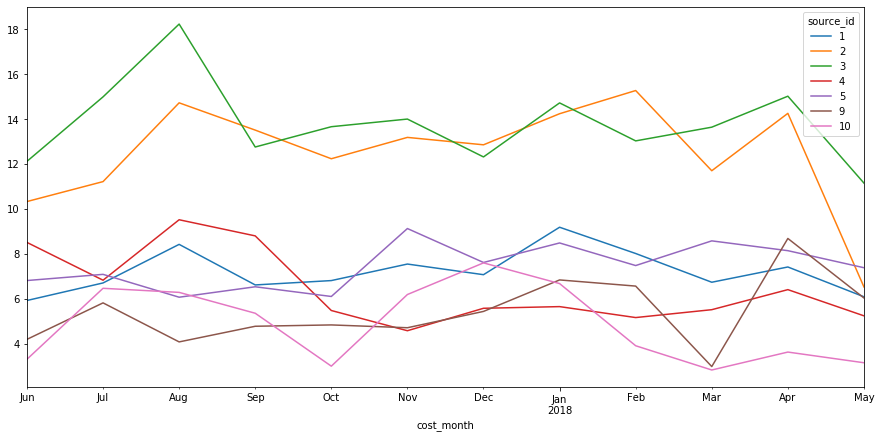

In [37]:
orders_and_source = sessions_first_source.merge(orders, on='uid')
orders_and_source
cohort_size_by_source = orders_and_source.groupby(['first_order_month', 'first_session_source'])['uid'].nunique()
cohort_size_by_source.name = 'cohort_size'

orders_by_source_cohort = orders_and_source.groupby(['first_order_month', 'first_session_source', 'lifetime'])\
                                           .agg({'revenue':'sum'}).reset_index()


costs_by_source = costs.groupby(['cost_month', 'source_id'])['costs'].sum().reset_index()

orders_by_source_cohort = orders_by_source_cohort.merge(costs_by_source, left_on=['first_order_month', 'first_session_source'],
                                                        right_on=['cost_month', 'source_id'])
orders_by_source_cohort = orders_by_source_cohort.merge(cohort_size_by_source, on=['first_order_month', 'first_session_source'])
orders_by_source_cohort['cac'] = orders_by_source_cohort['costs'] / orders_by_source_cohort['cohort_size']

cac_by_source = orders_by_source_cohort.pivot_table(index='cost_month', columns='source_id', values='cac')
cac_by_source.plot(figsize=(15,7))
plt.show()

#### Вывод

Август - самый дорогой месяц для привлечения новых клиентов для большинства источников.

Клиенты источников 3 и 2 самые дорогие.

Источник 4 привлекателен тем, что имеет средние расходы на привленение, но через него идет самый большой трафик.

#### ROMI

Источник  1


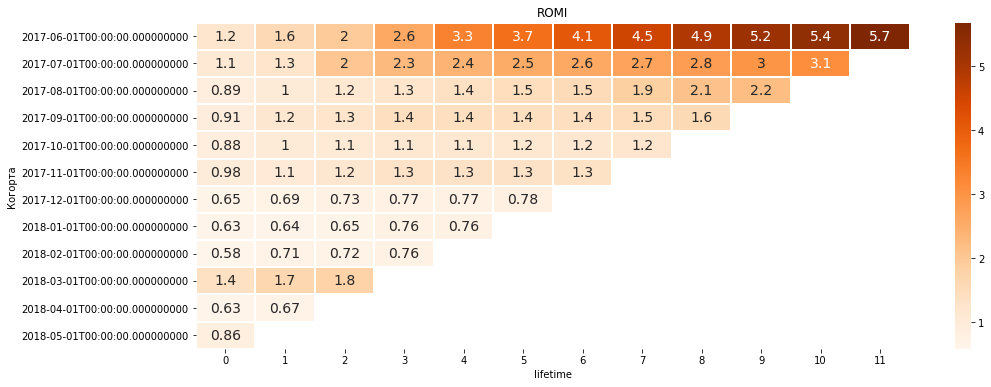

Источник  2


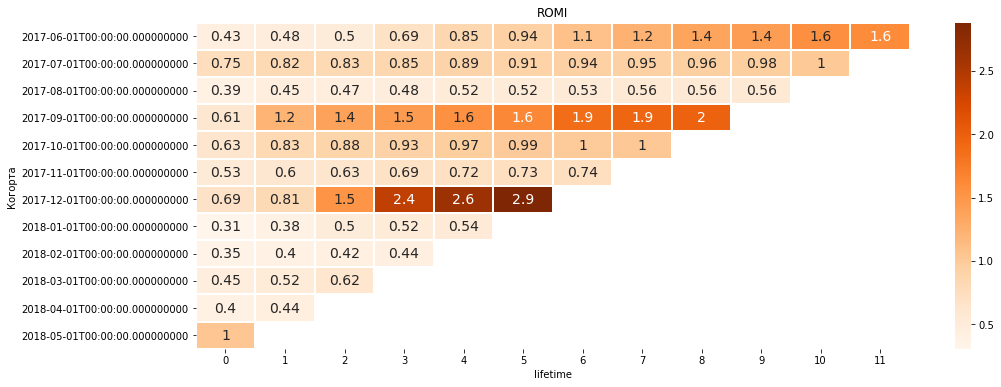

Источник  3


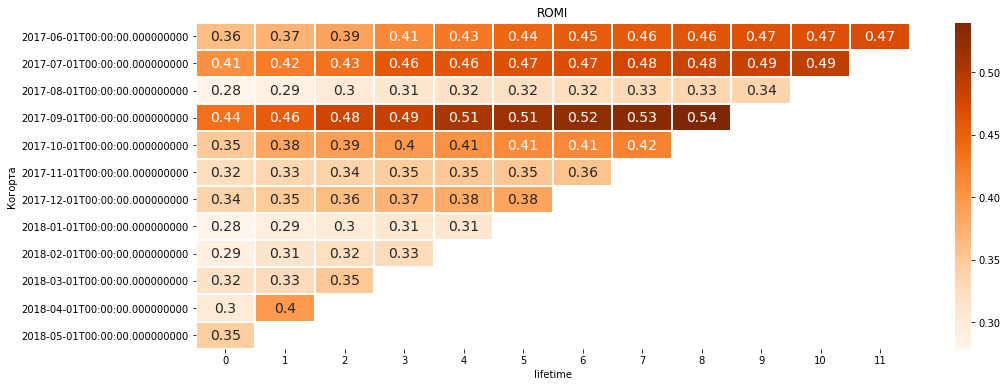

Источник  4


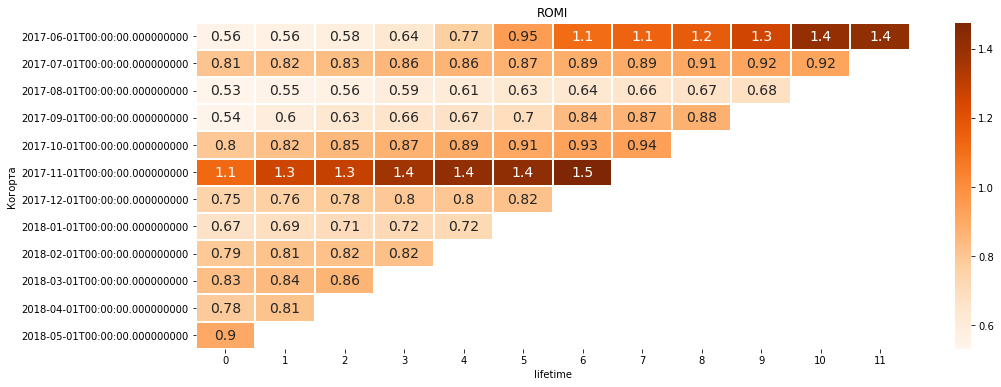

Источник  5


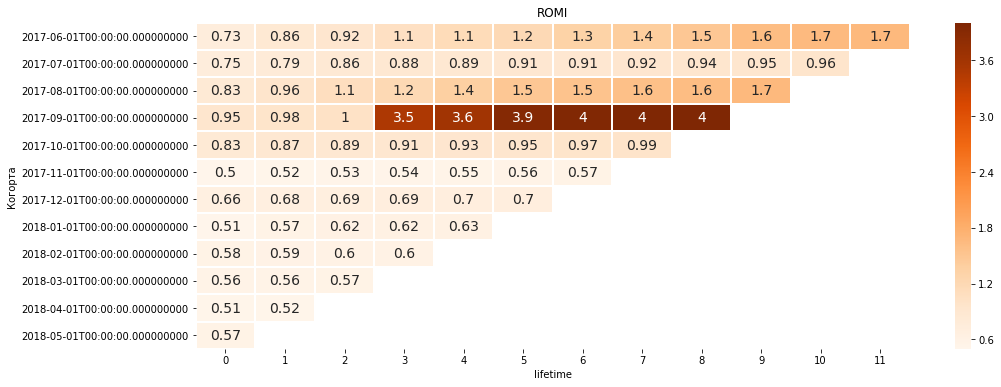

Источник  9


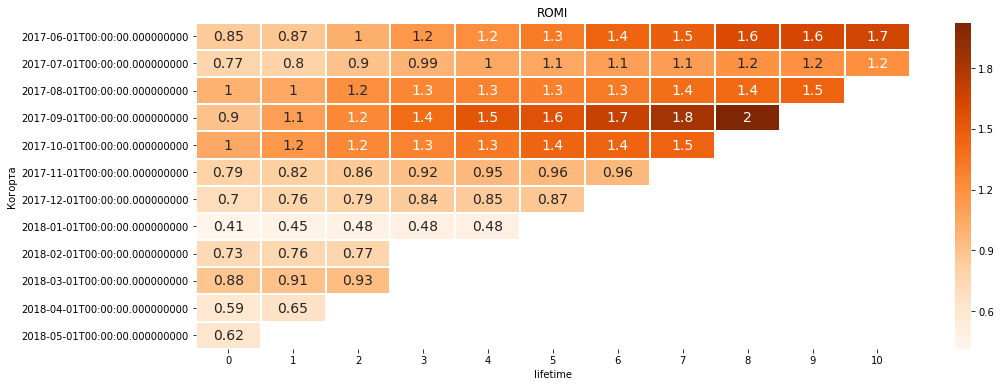

Источник  10


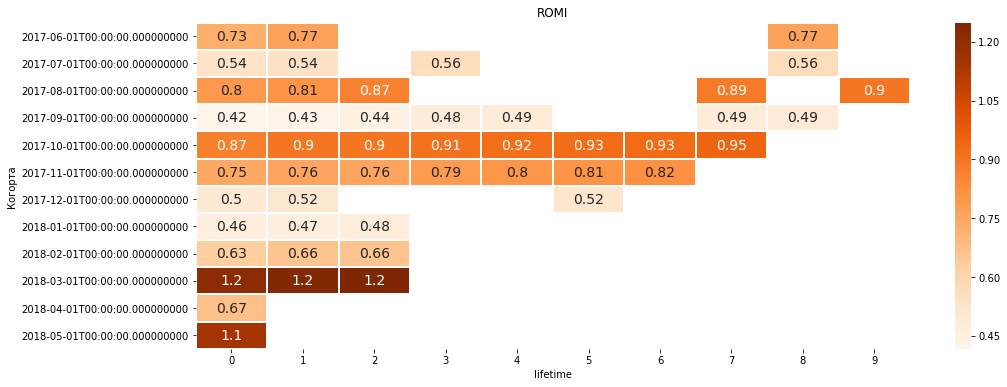

In [38]:
orders_by_source_cohort['ltv'] = orders_by_source_cohort['revenue'] / orders_by_source_cohort['cohort_size']
orders_by_source_cohort['romi'] = orders_by_source_cohort['ltv'] / orders_by_source_cohort['cac']

source_list = orders_by_source_cohort['source_id'].unique()
for source in source_list:
    pivot_romi = orders_by_source_cohort[orders_by_source_cohort['source_id']==source].pivot_table(index='first_order_month', 
                                                                                                  columns='lifetime',
                                                                                                  values='romi',
                                                                                                   aggfunc='mean')
    pivot_romi = pivot_romi.cumsum(axis=1)
    
    print('Источник ', source)
    
    plt.figure(figsize=(16,6))
    sns.heatmap(pivot_romi, linewidths=1, cmap='Oranges', annot=True, annot_kws={'size':14})
    plt.title('ROMI')
    plt.ylabel('Когорта')
    plt.show()

#### Вывод

**Источник 1**

Декабрь-февраль самые невыгодные месяцы для привлечения клиентов. Расходы для когорты 12-2017 не окупились через 6 меясцев. 
Самые лучшие результаты у когорт 06-2017, 07-2017, 03-2018. В эти месяцы расходы на маркетинг практически самые низкие, но маркетинговые расходы покрыты с первого месяца. 
Остальные когорты тоже показывают хороший результат - окупаемость со 2 месяца жизни.

С июня по ноябрь, март и май - хорошее время для увеличения маркетинговых расходов.

**Источник 2**

Клиенты источника 2 одни из самых дорогих. Отличные результаты показали когорты 09-2017 и 12-2017 - окупаемость со 2-3 месяца. Когорта 05-2018 полностью покрыла расходы с первого месяца, в то время как вложения были самые низкие.

Май, сентябрь и декабрь - лучшее время на привлечения клиентов. 

**Источник 3**

Затраты на привлечение клиентов самые высокие, но ни одна когорта не окупилась. 

**Источник 4**

Когорта 11-2017 ушла в плюс с первого месяца и в этом месяце стоимость привлечения одного клиента самая низкая. Стоит обратить внимание на увечиение бюджета привлечения в этот месяц. 

**Источник 5**

Клиенты, привлеченные в июне, августе и сентябре оправдались с 3-4 месяца жизни когорты. Сентябрьская когорта показала к 4 месяцу жизни окупаемость в 3,5 раза.

**Источник 9**

С июня по октябрь когорты показывают хорошую окупаемость. Август - самое благоприятное время для маркетинговых вложений: клиенты стоят дешевле остальных месяцев и покрыли расходы на привлечение с первого месяца. 

**Источник 10**

Когорты 03-2018 и 05-2018 выгодно отличаются на фоне остальных - покрытие маркетинговых расходов с 1 месяца. Клиенты этих когорт обошлись дешевле остальных когорт. 

## Вывод

В среднем ресурсом Яндекс.Афиша пользуются:
- 907 людей в день;
- 5716 людей в неделю;
- 23228 людей в месяц.

**Sticky_mau** всего 3 %. Показатель низкий, а значит, что механизмы вовзрата клиента требуют улучшения.

Больше всего пользуются ресурсом в ноябре. За этот месяц на сайт зашли около 38 000 человек.
Достаточно популярные месяцы - октябрь, ноябрь, январь, февраль и март.
Летние месяцы самые непопулярные по использованию ресурса.

Так же пик использования приложения приходится на 47 неделю, с 20 по 26 ноября. В это время, вероятно, люди покупают билеты на новогодние представления.

Среднее количество сессий в день на 1 пользователя - 1,08.

Показатель посещаемости для Источника 1 самый высокий - 1,15 сессий в день на одного пользователя.

Посещаемость на всех видах устройств примерно одинакова.

В среднем одна сессия длится 60 секунд.

Время, проведенное пользователями, которые перешли на сайт из источников 6 и 7, выбивается из общей массы.

Уже на второй месяц жизни когорты коэффициент удержания меньше 10%.
В целом, от когорты к когорте Retention Rate убывает на одних и тех же жизненных циклах. Это говорит о том, что поведение пользователей с каждой новой когортой меняется. 

Самый высокий коэффициент удержания у когорты 06-2017.

Повышение Retention Rate на 6 месяце жизни для когорты 06-2017, на 4 для когорты 07.2017, говорит о том, что к декабрю больше пользователей возвращаются на сайт.

За 60 секунд новый пользователь выбрал билеты и оплатил покупку.

Больше всего клиентов, оформивших покупку более одного раза за первые 6 месяцев жизни, у когорты 06-2017 - около 70%.
Для остальных когорт среднее количество покупок на 1 покупателя - 1,4.

Покупатели когорт 09-2017, 12-2017, 06-2017 совершают самые большие покупки. В среднем одна покупка приносит от 21 до 31 у.е..

У когорт 07-2017, 08-2017, 03-2018, 04-2018 средний чек 11 у.е..

Самые маленькие покупки у когорт 05-2018 и 06-2018.

Общее сходство в поведении всех когорт - в первом месяце жизни когорты средний чек самый низкий. Т.е. покупатели тратят больше денег со второй покупки.

Самые большие покупки некоторые когорты сделали на 4 месяце жизни, затем следующий пик на 7.

Самые ценные покупатели когорты 09-2017. Каждый в среднем принес 12 у.е. прибыли за первые 6 месяцев использования сервиса. Вероятно, эти клиенты пришли из источников 1,2,5 и 9.

Выручка от покупателей когорт 10-2017 и 11-2017 в среднем 6,2 у.е - это самый низкий показатель по сравнению с остальными. Тем не менне когорта 10-2017, пришедшая из источников 1 и 9 окупились с 1-2 месяца.

Покупатели остальных когорт приносят в среднем 7,7 у.е выручки каждый.

Рекомендации:
1. Пересмотреть целесообразность вложений в продвижение сервиса через исчточник 3.
2. Благоприятные месяцы для привлечения клиентов:
    - Источник 1 - с июня по ноябрь, март и май
    - Истчоник 2 - Май, сентябрь и декабрь
    - Источник 4 - ноябрь
    - Источник 5 - июнь, август, сентябрь
    - Источник 9 - с июня по октябрь и в частности август
    - Источник 10 - март и май
